Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import pickle

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [ ]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # 1. AZ PHX Sky Harbor Data #
# AZW_15 = pd.read_csv("./Data/Weather Data/KPHX-15.csv")

# # 2. ENVIMET DATA #
# BPS = []
# Fname = []
# for path in pathlib.Path("./Data/BPS").iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         BPS.append(current_file)
#         Fname.append(path.name.replace('.csv', ''))

# # Drop last row of EnviMet Data
# for i in range(len(BPS)):
#     BPS[i] = BPS[i].drop(16)

# # 3. CAMPUS METABOLISM DATA #
# metabol14 = []
# for path in pathlib.Path('./Data/ASU 2018').iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         metabol14.append(current_file)


# # 5. Save files as pickle
# AZW_15.to_pickle("./Data/AZW_15.pkl")

# with open('./Data/BPS.pkl', 'wb') as f:
#     pickle.dump(BPS, f)

# with open('./Data/Fname.pkl', 'wb') as f:
#     pickle.dump(Fname, f)

# with open('./Data/metabol14.pkl', 'wb') as f:
#     pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [2]:
# We will convert these to df depending on the building we choose
# 1. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 2. Load names of Envimet files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 3. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)


## 2.3 Choose files to import

### 2.3.1 Building name

In [3]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Health Services
Interdisciplinary AB
Bio Design Institute A
Lifescience A_B_D
Bio Design Institute B
COD North
Goldwater
University Club
Engineering Research Ctr
Best Hall
ISTB 1
ISTB 2
ISTB 4
ISTB 5


Enter building name:  Interdisciplinary AB


### 2.3.2 Choose baseline data (and year):

In [4]:
base_name = input('Enter \'asu\' or \'station\': ')
print('We will train using' , base_name, 'data')

if(base_name == 'asu'):
    year_picked = input('Enter year between 2017 - 2020 inclusive: ')
    print('You picked year: ', year_picked )

Enter 'asu' or 'station':  station


We will train using station data


## 2.4 Create Data Frame

In [5]:
# 1. DF for Envimet
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env



Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

Interdisciplinary AB


In [6]:
# 2. DF for weather
if(base_name == 'asu'):
    path_name = "./Data/ASU_Weather/x-weather(" + year_picked + ").csv"
    baseline_df = pd.read_csv(path_name)
    
    # get year
    baseline_df["Date and Time"] = pd.to_datetime(baseline_df["Date and Time"])
    baseline_df["year"] = baseline_df["Date and Time"].dt.year

    # remove wrong year
    baseline_df = baseline_df[baseline_df["year"] == int(year_picked)]
    
    # remove year and unnamed column
    baseline_df = baseline_df.iloc[: , :-2]
    
    # rename column
    new_column = ['Date_Time', 'Dew', 'Air Temp', 'Rel Humid', 'Solar Rad', 'Wind']
    baseline_df.set_axis(new_column, axis =1, inplace = True)

    # choose column
    baseline_df = baseline_df[['Date_Time','Air Temp', 'Rel Humid']]    

    # convert date time to string
    baseline_df['Date_Time'] = baseline_df['Date_Time'].dt.strftime('%m/%d/%Y %H:%M')
    
    # Convert temp. from F to C
    baseline_df = baseline_df.assign(Air = lambda x: (5/9) * (x['Air Temp'] - 32))
    baseline_df['Air Temp'] = baseline_df['Air']
    baseline_df.drop(columns = ['Air'], inplace = True)
else:
    # 3. DF for weather station (15-min)
    baseline_df = pd.read_pickle('./Data/AZW_15.pkl')   

baseline_df

,Date_Time,Air Temp,Rel Humid
0,01/01/2018 00:00,11.0,40.24
1,01/01/2018 00:15,11.0,40.24
2,01/01/2018 00:30,10.0,43.01
3,01/01/2018 00:45,9.0,46.00
4,01/01/2018 01:00,9.0,46.00
...,...,...,...
34624,12/31/2018 22:00,6.0,93.30
34625,12/31/2018 22:15,5.0,100.00
34626,12/31/2018 22:30,5.0,100.00
34627,12/31/2018 22:45,6.0,93.30


# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [7]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

envimet = envimet.set_index('Date_Time')


['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']


<ipython-input-7-9e6431319558>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  envimet['Time'] = envimet['Time'].str.replace('.',':')


In [ ]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

### b) Baseline weather dates

In [8]:
# 1. Get string type for month and time
baseline_df['Month'] = baseline_df['Date_Time'].str[0:2]
baseline_df['Time'] = baseline_df['Date_Time'].str[11:]
baseline_df['Time'] = baseline_df['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
baseline_df.Date_Time = pd.to_datetime(baseline_df.Date_Time) # convert to datetime object
baseline_df['Month_num'] = baseline_df.Date_Time.dt.month 
baseline_df['Hour_num'] = baseline_df.Date_Time.dt.hour
baseline_df['Minute_num'] = baseline_df.Date_Time.dt.minute
baseline_df.Date_Time = pd.to_datetime(baseline_df.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
baseline_df = baseline_df.set_index('Date_Time')

### d) Building energy dates

In [9]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')

## 3.2 Append Energy Consumption to baseline weather data

In [10]:
baseline_df =  pd.concat([metabol, baseline_df], axis = 1, join = "inner")

# rearrange column
baseline_df = baseline_df[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# save data with string and numeric date format
baseline_df.to_csv('./Data/' + base_name +'.csv') 

In [11]:
baseline_df

,Month,Time,Month_num,Hour_num,Minute_num,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,01,0000,1,0,0,11.0,40.24,138.33,1.09
01/01/2018 00:15,01,0015,1,0,15,11.0,40.24,90.14,0.99
01/01/2018 00:30,01,0030,1,0,30,10.0,43.01,80.49,1.01
01/01/2018 00:45,01,0045,1,0,45,9.0,46.00,84.88,0.90
01/01/2018 01:00,01,0100,1,1,0,9.0,46.00,85.83,0.87
...,...,...,...,...,...,...,...,...,...
12/31/2018 22:00,12,2200,12,22,0,6.0,93.30,124.28,0.00
12/31/2018 22:15,12,2215,12,22,15,5.0,100.00,127.61,0.00
12/31/2018 22:30,12,2230,12,22,30,5.0,100.00,130.48,0.00
12/31/2018 22:45,12,2245,12,22,45,6.0,93.30,133.01,0.00


<AxesSubplot:title={'center':'Air Temp'}, xlabel='Month'>

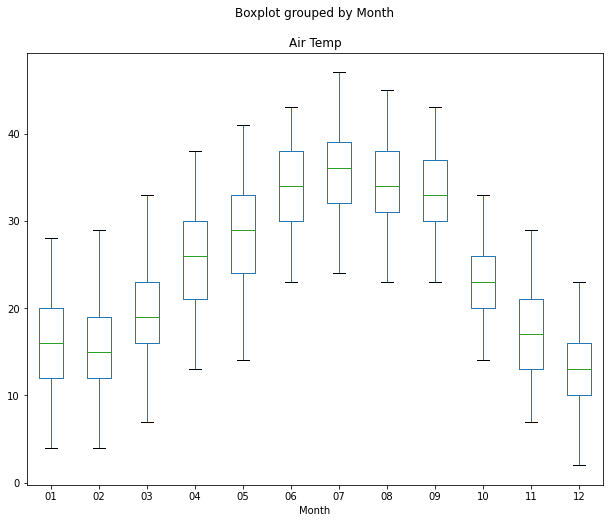

In [12]:
baseline_df.boxplot(by ='Month', column =['Air Temp'], grid = False, figsize = (10, 8))

<AxesSubplot:title={'center':'CHWTON'}, xlabel='Month'>

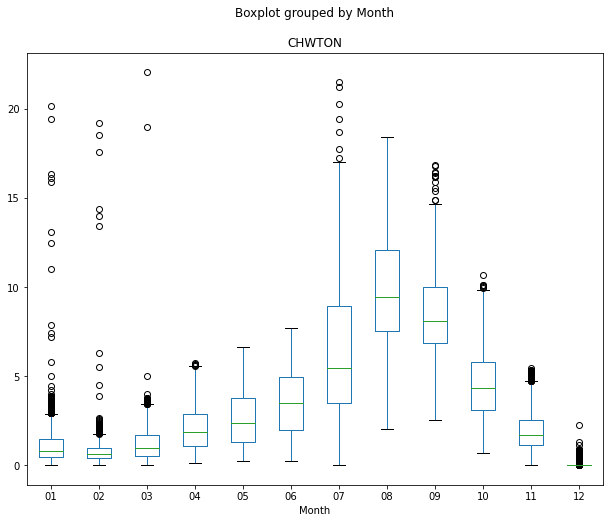

In [13]:
baseline_df.boxplot(by ='Month', column =['CHWTON'], grid = False, figsize = (10, 8))

# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [14]:
envimet_j9 = pd.merge(envimet, metabol, left_index = True, right_index = True)
envimet_j9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,29.288046,12.926082,93.54,2.08
06/09/2018 06:00,06,0600,28.547272,17.865186,117.23,1.22
06/09/2018 07:00,06,0700,29.235614,18.867418,103.66,1.36
06/09/2018 08:00,06,0800,31.330512,18.101223,106.36,2.67
06/09/2018 09:00,06,0900,33.952092,15.256233,105.26,2.71
06/09/2018 10:00,06,1000,35.924490,11.618912,103.63,3.53
06/09/2018 11:00,06,1100,36.924873,9.391644,105.14,4.02
06/09/2018 12:00,06,1200,37.832170,8.080515,103.65,5.69
06/09/2018 13:00,06,1300,38.753659,7.134143,105.62,4.84
06/09/2018 14:00,06,1400,39.469672,6.435761,102.44,4.79


## 4.2 For Baseline

In [15]:
# 1. Convert to datetime so we can remove June 9th weather
baseline_df.index = pd.to_datetime(baseline_df.index)

# 2. Extract all of june 9th data 
baseline_j9 = baseline_df[(baseline_df.index.month == 6) & (baseline_df.index.day == 9)]

# 3. drop all of June 9th from baseline_df data
baseline_df = baseline_df.drop(baseline_j9.index)

# 4. Filter time ( only minute 00) from june 9th data
baseline_j9 = baseline_j9[ (baseline_j9['Hour_num'] >= 5) & (baseline_j9['Hour_num'] <= 20) & (baseline_j9['Minute_num'] == 0)]

# 5. drop numeric variables
baseline_df = baseline_df.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)
baseline_j9 = baseline_j9.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)

# 6. ensure theres no more june 9th data between 5am to 8pm on baseline_df data
print(baseline_df[(baseline_df.index.month == 6) & (baseline_df.index.day == 9)])

# 7. convert index back to string types
baseline_df.index = pd.to_datetime(baseline_df.index).strftime('%m/%d/%Y %H:%M')
baseline_j9.index = pd.to_datetime(baseline_j9.index).strftime('%m/%d/%Y %H:%M')
baseline_j9

Empty DataFrame
Columns: [Month, Time, Air Temp, Rel Humid, KW, CHWTON]
Index: []


,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,27.0,14.84,93.54,2.08
06/09/2018 06:00,06,0600,26.0,15.74,117.23,1.22
06/09/2018 07:00,06,0700,28.0,17.42,103.66,1.36
06/09/2018 08:00,06,0800,31.0,11.78,106.36,2.67
06/09/2018 09:00,06,0900,33.0,9.06,105.26,2.71
06/09/2018 10:00,06,1000,35.0,7.52,103.63,3.53
06/09/2018 11:00,06,1100,37.0,6.74,105.14,4.02
06/09/2018 12:00,06,1200,39.0,5.19,103.65,5.69
06/09/2018 13:00,06,1300,41.0,4.32,105.62,4.84
06/09/2018 14:00,06,1400,41.0,3.99,102.44,4.79


In [16]:
# save as csv
envimet_j9.to_csv('./Data/envimet_j9.csv')

## Plot temperature and humidty differences

<AxesSubplot:title={'center':'Interdisciplinary AB Air Temperature'}, xlabel='Time'>

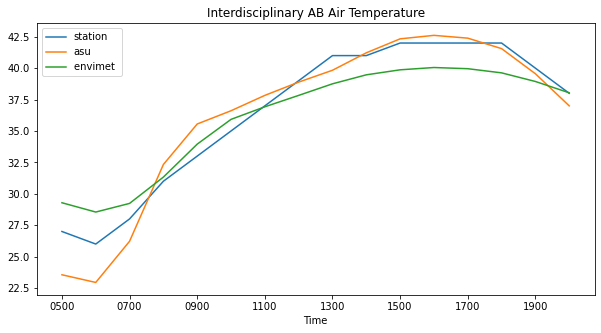

In [17]:
# 1. Get station_j9, asu_j9
station_j9 = pd.read_csv("./Data/station_j9.csv", index_col=0)
asu_j9 = pd.read_csv("./Data/asu_j9.csv", index_col=0)

temp_df = pd.DataFrame()
name = ['station', 'asu', 'envimet ']
dfs = [station_j9, asu_j9, envimet_j9]

# 2. get air temp in each df
i = 0
for df in dfs:
    temp_df[name[i]] = df['Air Temp']
    i+= 1


# 3. Set time as index
temp_df['Time'] = baseline_j9['Time']
temp_df = temp_df.set_index('Time')

# 4. plot
temp_df.plot(figsize=(10, 5), title = bldname + ' Air Temperature')

<AxesSubplot:title={'center':'Interdisciplinary AB Rel Humidity'}, xlabel='Time'>

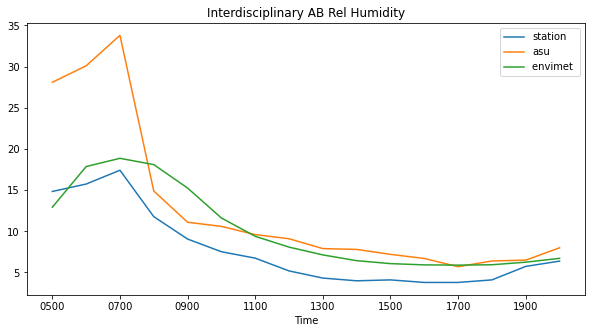

In [18]:
# 1. get humidty in each df
humid_df = pd.DataFrame()
i = 0
for df in dfs:
    humid_df[name[i]] = df['Rel Humid']
    i+= 1

# 2. Set time as index
humid_df['Time'] = baseline_j9['Time']
humid_df = humid_df.set_index('Time')

# 3. plot 
humid_df.plot(figsize=(10, 5), title = bldname + ' Rel Humidity')

# 5. EDA

## 5.1 Correlation Matrix

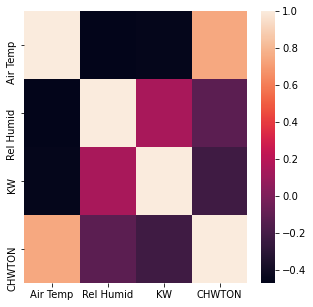

In [19]:
corrMatrix = baseline_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corrMatrix)
plt.show()

## 5.2 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [20]:
## Get X and Y
Y = baseline_df['CHWTON']
X = baseline_df.drop(labels = ['CHWTON'], axis = 1)

X_int = X.drop(labels = ['Month', 'Time'], axis = 1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

vif_data

,feature,VIF
0,Air Temp,3.925219
1,Rel Humid,3.273488
2,KW,6.620458


## 5.3 Remove Outliers

## 5.4 Scaling

# 6. Model 1: Random Forest

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 Train Test (all year)

In [21]:
############################ RANDOM FORESTS #################################3
# 1. import library
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 1. Split into train test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# 3. Train data
base_RF.fit(X_train, Y_train)

# 4. Get prediction
Y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                  Actual CHWTON  Predicted CHWTON
01/01/2018 00:15           0.99            2.5217
01/01/2018 00:30           1.01            1.1789
01/01/2018 00:45           0.90            0.8819
01/01/2018 02:00           1.06            1.0375
01/01/2018 03:15           0.92            0.7448
...                         ...               ...
12/31/2018 17:30           0.00            0.0000
12/31/2018 18:45           0.00            0.0000
12/31/2018 22:15           0.00            0.0051
12/31/2018 22:45           0.00            0.0000
12/31/2018 23:00           0.00            0.0006

[6906 rows x 2 columns]


In [22]:
# Custom functions for scoring
# 1. This function will returns R2 and RMSE score given a model and X, Y tests data
def evaluate(model, X_tests, Y_tests):
    Y_preds = model.predict(X_tests)
    R2 = model.score(X_tests, Y_tests)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_tests, Y_preds))
    return [R2, RMSE]

# 2. This function will append a new all year score (row) to our scores data frame
def append_all_year_score(dataframe, score_list, model_name):
    i = dataframe.shape[0] # new index
    dataframe.loc[ i, 'model' ] = model_name
    dataframe.loc[ i, ('all_year','R2') ] = score_list[0]
    dataframe.loc[ i, ('all_year','RMSE') ] = score_list[1]
    return dataframe

# 3. This function will append a new June 9th score (column) to our scores data frame of the last row
def append_j9_score(dataframe, score_list, isEnvimet = False):
    data_name = 'baseline'
    if(isEnvimet == True):
        data_name = 'envimet'
        
    i = dataframe.shape[0] - 1 # last index
    dataframe.loc[i, (data_name, 'R2')] = score_list[0]
    dataframe.loc[i, (data_name, 'RMSE')] = score_list[1]

    return dataframe


# 4. This function will append all scores to score df
def get_model_score_df(pModel, pX_test, pY_test, pX_j9, pX_j9_envi, pY_j9, pScore_df, pModel_name):
    # 1. all year 
    all_year_score = evaluate(pModel, pX_test, pY_test)
    pScore_df = append_all_year_score(pScore_df, all_year_score, pModel_name) # append to score_df
    
    # 2. weather station
    weather_st_score = evaluate(pModel, pX_j9, pY_j9) 
    pScore_df = append_j9_score(pScore_df, weather_st_score, isEnvimet = False) 
    
    # 3. envimet
    envimet_score = evaluate(pModel, pX_j9_envi, pY_j9) # get score
    pScore_df = append_j9_score(pScore_df, envimet_score, isEnvimet = True)

    return pScore_df


In [23]:
# 1. get score
r2rmse = evaluate(base_RF, X_test, Y_test)

# 2. create score df
arrays = [["all_year", "all_year"],['R2', 'RMSE']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)
scores_df = pd.DataFrame([[2,1]], columns=index)

# 3. fill model name and score
scores_df['model'] = 'base RF'
scores_df['all_year', 'R2'] = r2rmse[0]
scores_df['all_year', 'RMSE'] = r2rmse[1]
scores_df = scores_df[['model', 'all_year']]
scores_df


model  all_year          
                  R2      RMSE
0  base RF  0.937572  0.896675

In [24]:
# Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(base_RF.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.539102
Month        0.251560
Time         0.123118
KW           0.046696
Rel Humid    0.039524
dtype: float64 



## 6.2 June 9th Prediction

### Baseline

In [25]:
# 1. Get X and Y (all test)
X_j9 = baseline_j9.drop(labels = ['CHWTON'], axis = 1)
Y_j9 = baseline_j9['CHWTON']

# 2. calc scores 
base_score = evaluate(base_RF, X_j9, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = False)

### Microclimate

In [26]:
# 1. Get X and Y (all test)
X_j9_envi = envimet_j9.drop(labels = ['CHWTON'], axis = 1)

# 2. calc scores 
base_score = evaluate(base_RF, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = True)
scores_df

model  all_year            baseline             envimet          
                  R2      RMSE        R2      RMSE        R2      RMSE
0  base RF  0.937572  0.896675  0.876395  0.491681  0.854852  0.532807

# 7. Model 2: RF using Randomized Search

## 7.1 Set parameters grid

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## 7.2 Train, Test, Score

In [28]:
# Use the random grid to search for best hyperparameters
# 1.Create the base model to tune
rf = RandomForestRegressor(random_state = 42)

# 2. Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 3. Fit the random search model
rf_random.fit(X_train, Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(rf_random.best_estimator_.get_params())
pprint(rf_random.best_score_)

# 5. get the best model
random_RF = rf_random.best_estimator_


# 6. get all score as df
scores_df = get_model_score_df(random_RF,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random RF')    
scores_df 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
0.9344830622621197


model  all_year            baseline             envimet          
                    R2      RMSE        R2      RMSE        R2      RMSE
0    base RF  0.937572  0.896675  0.876395  0.491681  0.854852  0.532807
1  random RF  0.938664  0.888797  0.866795  0.510416  0.837015  0.564596

In [ ]:
# #  1. Get all yearscore
# random_rf_score = evaluate(random_RF, X_test, Y_test)
# scores_df = append_all_year_score(scores_df, random_rf_score , 'random RF')

# # 2. Weather Station
# random_score = evaluate(random_RF, X_j9, Y_j9)
# scores_df = append_j9_score(scores_df, random_score, isEnvimet = False)

# # 3. Microclimate
# random_score = evaluate(random_RF, X_j9_envi, Y_j9)
# scores_df = append_j9_score(scores_df, random_score, isEnvimet = True)
# scores_df

# 8. Model 3: Catboost

## 8.1 Grid Search

In [29]:
import catboost as cb

# 1. initialize model and grid
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'depth': [2, 4, 8, 10],
        'iterations': [50, 100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5]}


# 2. search parameter
train_dataset = cb.Pool(X_train, Y_train) 
test_dataset = cb.Pool(X_test, Y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit = True,
                           verbose = True,
                           train_size = 0.8 )


# 3. get best params
params = result['params']

# 4. fit model with best params
grid_CB = cb.CatBoostRegressor(depth = params['depth'],  iterations = params['iterations'], learning_rate= params['learning_rate'], l2_leaf_reg = params['l2_leaf_reg'])
grid_CB.fit(train_dataset)

# 5. get score as df
scores_df = get_model_score_df(grid_CB,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'grid CB')    


0:	learn: 4.8500920	test: 4.7627861	best: 4.7627861 (0)	total: 64.6ms	remaining: 3.17s
1:	learn: 4.7351865	test: 4.6497059	best: 4.6497059 (1)	total: 68.6ms	remaining: 1.65s
2:	learn: 4.6261888	test: 4.5427558	best: 4.5427558 (2)	total: 70.8ms	remaining: 1.11s
3:	learn: 4.5190784	test: 4.4373597	best: 4.4373597 (3)	total: 73.5ms	remaining: 845ms
4:	learn: 4.4186014	test: 4.3388552	best: 4.3388552 (4)	total: 75.8ms	remaining: 682ms
5:	learn: 4.3229292	test: 4.2453062	best: 4.2453062 (5)	total: 78.1ms	remaining: 573ms
6:	learn: 4.2260343	test: 4.1499267	best: 4.1499267 (6)	total: 81.1ms	remaining: 498ms
7:	learn: 4.1335352	test: 4.0592447	best: 4.0592447 (7)	total: 83.6ms	remaining: 439ms
8:	learn: 4.0438580	test: 3.9707108	best: 3.9707108 (8)	total: 85.9ms	remaining: 391ms
9:	learn: 3.9591913	test: 3.8878761	best: 3.8878761 (9)	total: 88.9ms	remaining: 356ms
10:	learn: 3.8757004	test: 3.8054593	best: 3.8054593 (10)	total: 91.2ms	remaining: 323ms
11:	learn: 3.7961294	test: 3.7274154	best

In [30]:
print(params)
scores_df

{'depth': 10, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 0.2}


model  all_year            baseline             envimet          
                    R2      RMSE        R2      RMSE        R2      RMSE
0    base RF  0.937572  0.896675  0.876395  0.491681  0.854852  0.532807
1  random RF  0.938664  0.888797  0.866795  0.510416  0.837015  0.564596
2    grid CB  0.930688  0.944819  0.854952  0.532624  0.819747  0.593753

## 8.2 Random Search

In [31]:
catboost = cb.CatBoostRegressor(loss_function='RMSE')

# 1. hyperparameter grid
grid = {'iterations': [50, 100, 150, 200, 250],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8, 10, 12],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7]}

# 2. instantiate RandomSearchCv object
catboost_random = RandomizedSearchCV(estimator = catboost,
                               param_distributions = grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)


# 3. Fit the model
catboost_random.fit(X_train,Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(catboost_random.best_estimator_.get_params())
pprint(catboost_random.best_score_)

# 5. get the best model
random_CB = catboost_random.best_estimator_

# 6. get score
scores_df = get_model_score_df(random_CB,
                               X_test, Y_test,
                               X_j9,X_j9_envi,
                               Y_j9,
                               scores_df,
                               'random CB')    


Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 3.2332258	total: 80.2ms	remaining: 20s
1:	learn: 2.9701749	total: 152ms	remaining: 18.8s
2:	learn: 2.7325501	total: 232ms	remaining: 19.1s
3:	learn: 2.5376245	total: 240ms	remaining: 14.8s
4:	learn: 2.3509383	total: 318ms	remaining: 15.6s
5:	learn: 2.1862734	total: 385ms	remaining: 15.6s
6:	learn: 2.0449383	total: 453ms	remaining: 15.7s
7:	learn: 1.9186289	total: 530ms	remaining: 16s
8:	learn: 1.8025016	total: 605ms	remaining: 16.2s
9:	learn: 1.7020145	total: 671ms	remaining: 16.1s
10:	learn: 1.6135023	total: 738ms	remaining: 16s
11:	learn: 1.5355444	total: 822ms	remaining: 16.3s
12:	learn: 1.4704018	total: 890ms	remaining: 16.2s
13:	learn: 1.4137322	total: 959ms	remaining: 16.2s
14:	learn: 1.3647395	total: 1.05s	remaining: 16.4s
15:	learn: 1.3193754	total: 1.11s	remaining: 16.3s
16:	learn: 1.2777395	total: 1.23s	remaining: 16.8s
17:	learn: 1.2449525	total: 1.39s	remaining: 17.9s
18:	learn: 1.2138777	total: 1.53s	r

In [32]:
print(bldname)
scores_df

Interdisciplinary AB


model  all_year            baseline             envimet          
                    R2      RMSE        R2      RMSE        R2      RMSE
0    base RF  0.937572  0.896675  0.876395  0.491681  0.854852  0.532807
1  random RF  0.938664  0.888797  0.866795  0.510416  0.837015  0.564596
2    grid CB  0.930688  0.944819  0.854952  0.532624  0.819747  0.593753
3  random CB  0.934997  0.914980  0.857463  0.527993  0.833031  0.571456

# 9. Save Scores

In [33]:
import os
scores_df['bld_name'] = bldname
scores_df = scores_df[['bld_name', 'model', 'all_year', 'baseline', 'envimet']]
scores_df


bld_name      model  all_year            baseline            \
                                          R2      RMSE        R2      RMSE   
0  Interdisciplinary AB    base RF  0.937572  0.896675  0.876395  0.491681   
1  Interdisciplinary AB  random RF  0.938664  0.888797  0.866795  0.510416   
2  Interdisciplinary AB    grid CB  0.930688  0.944819  0.854952  0.532624   
3  Interdisciplinary AB  random CB  0.934997  0.914980  0.857463  0.527993   

    envimet            
         R2      RMSE  
0  0.854852  0.532807  
1  0.837015  0.564596  
2  0.819747  0.593753  
3  0.833031  0.571456

In [34]:
if(base_name == 'station'):
    pathname = './Data/scores.csv'
else:
    pathname = './Data/scores_asu.csv'

In [35]:
# if file does not exist write header 
if not os.path.isfile(pathname):
    scores_df.to_csv(pathname, header='column_names')
else: # else it exists so append without writing the header
    with open(pathname,'a') as f:
        f.write('\n')  # got to next line before writing
    scores_df.to_csv(pathname, index = True, header = False, mode='a')

# 10. Get prediction of best model

In [36]:
# 1. get best model
best_model = grid_CB

# 2. get weather station prediction
Y_pred_j9 = best_model.predict(X_j9)

# 3. get envimet prediction
Y_pred_j9_envi = best_model.predict(X_j9_envi)

# 4. show predictions
Pred = pd.DataFrame({'Actual':Y_j9,'Baseline Predictions (AZW)': Y_pred_j9, 'Microclimate Predictions': Y_pred_j9_envi})
Pred

,Actual,Baseline Predictions (AZW),Microclimate Predictions
06/09/2018 05:00,2.08,1.697114,2.184297
06/09/2018 06:00,1.22,1.506796,2.256869
06/09/2018 07:00,1.36,1.899658,2.293107
06/09/2018 08:00,2.67,2.603281,2.713569
06/09/2018 09:00,2.71,3.058257,3.255419
06/09/2018 10:00,3.53,3.224277,3.907144
06/09/2018 11:00,4.02,4.059946,4.103403
06/09/2018 12:00,5.69,4.130175,4.231725
06/09/2018 13:00,4.84,4.820115,4.402678
06/09/2018 14:00,4.79,4.922273,4.533048


# 11. Hypothesis Test

3.835738509680967
3.8069757708165746
mu: 0.02876273886439229


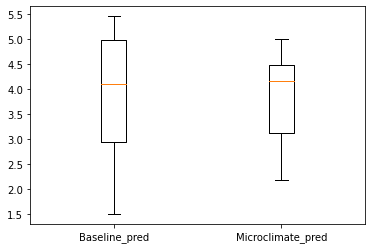

In [37]:
plt.boxplot([Y_pred_j9, Y_pred_j9_envi])
plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])
print(Y_pred_j9.mean())
print(Y_pred_j9_envi.mean())
print('mu:', Y_pred_j9.mean()- Y_pred_j9_envi.mean())

# Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate}$ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 11.1 calculate standard deviation

In [38]:
# 1.variance
var_baseline = Y_pred_j9.var(ddof = 1)
var_micro = Y_pred_j9_envi.var(ddof = 1)
print('var:',var_baseline, var_micro)

# 2. standard deviation
s = np.sqrt((var_baseline + var_micro)/2)
print('s:',s)

var: 1.8849070541641977 0.9565279116768944
s: 1.1919385399090618


## 11.2 calculate T-statistic

In [39]:
import scipy.stats as stats
t_stat, p_val = stats.ttest_ind(Y_pred_j9, Y_pred_j9_envi, equal_var=False)
print('t statistics: ', t_stat)
print('p value: ', p_val)

t statistics:  0.06825294095469502
p value:  0.9460852780529608


P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 12. Plot

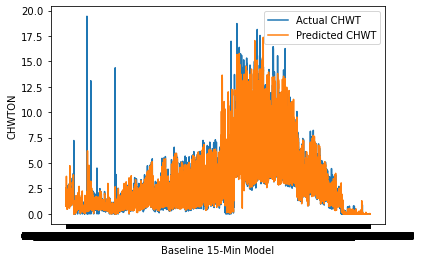

In [40]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

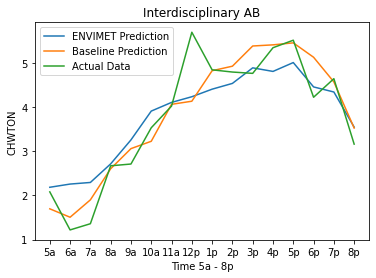

In [41]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Prediction')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Prediction')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title(bldname)
plt.legend()

## show graphs
plt.show()